In [1]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Primer filtro (5%)

## Cargamos los datos

In [3]:
data = Data(layer_size=16)
train, val, test = data.get_splits(['random_subsample'], [[0.05, 0.95]])
train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)
experiment_name = "05per"

c:\Users\juand\anaconda3\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


Number of samples: 198 train | 754 val | 3017 test


## Importamos los modelos que vamos a usar

In [4]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))

<All keys matched successfully>

# LSTM

## Generamos el explainer

In [5]:
feature_names_mapped = [
    data.feature_names_one_hotted[i] if i < len(data.feature_names_one_hotted) else f"feature_{i}"
    for i in range(384)
]

In [6]:
from lime.lime_tabular import LimeTabularExplainer

# Crear el explainer con nombres reales en lugar de índices
explainer = LimeTabularExplainer(
    training_data=x_train,  # Datos 2D
    mode="classification",
    feature_names=feature_names_mapped,  # Ahora con nombres reales
    class_names=["A", "D", "R", "V"],
    discretize_continuous=False
)

## Funcion predict

In [10]:
#  realiza la predicción sobre un conjunto de datos 
def predict_fn_LIME_LSTM(x_test):
    best_lstm_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)

    aux=[]
    aux.append(x_test[0])
    
    #print(data.reverse_encoding(aux))
    x = data.to_lstm_format(x_test)  # Convertir a la forma LSTM 
    
    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_lstm_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        #ret = output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)
        probabilities = torch.softmax(output, dim=1).cpu().numpy() # Convertir a probabilidades
        return probabilities
#predict_fn(x_train)

## Generamos la explicacion

In [11]:
# Seleccionar una muestra para explicar
i = 3000
# Generar la explicación
explanation = explainer.explain_instance(
    data_row=x_test[i],
    predict_fn=predict_fn_LIME_LSTM,
    num_features=10,
    #num_samples=50,
    top_labels=4
)

# Mostrar la explicación en Jupyter Notebook
print(f"Muestra a explicar numero {i}: {test_original[i]}")
#print(f"Muestra a explicar: {train_original[i]}")  
explanation.show_in_notebook()


Muestra a explicar numero 3000: ['_..__,_._..__,_.', '_._wu,,.._._,,_,', ',,,_,._dr,._,._,', 'V']


# CNN

## Generamos el explainer

In [14]:
explainer_cnn = LimeTabularExplainer(
    training_data=x_train,  # Datos de entrenamiento (formato [N, 128])
    mode="classification",
    feature_names=feature_names_mapped,  # Nombres de las features
    class_names=["A", "D", "R", "V"],  # Nombres de las clases
    discretize_continuous=False  # LIME puede discretizar, pero es mejor desactivarlo
)


In [15]:
#  realiza la predicción sobre un conjunto de datos 
def predict_fn_LIME_CNN(x_test):
    best_cnn_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)
    aux=[]
    aux.append(x_test[0])
    
    #print(data.reverse_encoding(aux))
    x = data.to_conv_format(x_test)   # Convertir a la forma CNN

    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_cnn_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        return output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)


## Generamos la explicacion

In [16]:
# Seleccionar una muestra para explicar
i = 409

# Generar la explicación
explanation_cnn = explainer_cnn.explain_instance(
    data_row=x_test[i],
    predict_fn=predict_fn_LIME_CNN,
    num_features=10,
    top_labels=4
)



# Mostrar la explicación en Jupyter Notebook
print(f"Muestra a explicar {test_original[i]}")
explanation_cnn.show_in_notebook()


c:\Users\franm\AppData\Local\Programs\Python\Python311\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


Muestra a explicar [',.._,,.,....,.,,', '_..,_,,.,w_.,_,.', '.___,.,,,,._,._,', 'V']


# 4ª filtro (variable interop distance)

## Generamos los datos

In [118]:
data = Data(layer_size=16, interop_distances=[0,1,2])
train, val, test = data.get_splits(['omit_distances', 'random_subsample'], [[1], [0.25, 0.75]]) # se omitirán muestras con una distancia de 1 entre operaciones relevantes, a partir de los datos obtenidos el 25% de los datos restantes irá a validación y el 75% a prueba.

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(x_train)
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)
experiment_name = "interop_1"

c:\Users\juand\anaconda3\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


Number of samples: 1988 train | 941 val | 3765 test


## Cargamos los modelos

In [119]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))

<All keys matched successfully>

# LSTM

## Generamos el explainer

In [120]:
from lime.lime_tabular import LimeTabularExplainer

# Crear el explainer con nombres reales en lugar de índices
explainer_LIME_lstm = LimeTabularExplainer(
    training_data=x_train,  # Datos 2D
    mode="classification",
    feature_names=feature_names_mapped,  # Ahora con nombres reales
    class_names=["A", "D", "R", "V"],
    discretize_continuous=False
)

## Funcion predict

In [146]:
#  realiza la predicción sobre un conjunto de datos 
def predict_fn_LSTM(x_test):
    best_lstm_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)
    aux=[]
    aux.append(x_test[0])
    #print(data.reverse_encoding(aux))
    x = data.to_lstm_format(x_test)  # Convertir a la forma LSTM 
    
    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_lstm_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        #ret = output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)
        probabilities = torch.softmax(output, dim=1).cpu().numpy() # Convertir a probabilidades
        return probabilities


## Generamos explicacion

In [147]:
for i in range(len(test_original)):
    print(f"{i}:{test_original[i]}")

0:['__.,,,.,__,,..,,', 'w,u._,,_.,,.._._', '_.c_r,..__,_,.,,', 'V']
1:['__._,_,.._..,.,_', '__..w_u,.,_.,._.', '..,d,r__..._..__', 'V']
2:[',__.__.,_._,._._', '..,,_,__,.,u.w,.', '_.___,_d.r.._,,.', 'A']
3:['..,__,.._.,_,.._', '__._..__._..__._', '__._,..__r,_.,_.', 'R']
4:['.....__,...,.,_,', '_..u,w,,_.,____,', '..,,,,_d,r,_.._.', 'A']
5:[',.,._,.__,,__.,,', '..___._.,.u_w..,', '_..__,_,,,__r_..', 'R']
6:['.,,._,_,,.,,,_._', '..,_._,,._.,,_..', ',,____,.c.r___,,', 'V']
7:[',__,._,.___._.__', ',,.,__,._,,,_._,', ',.,c_r.,,,,_,__,', 'V']
8:['.....__,.....__.', '__.w.._,._,._,,.', '..__c,r_,_,_..,.', 'V']
9:[',._,,,,.,_,.,..,', 'w.__,._._.____..', '__,,.,_,r.......', 'R']
10:['._,.,_,._.._,,_.', ',_.,..,__u_w_..,', '.,_.,_,,_____.,.', 'V']
11:['__..,,______._.,', ',,.,._w,,_.,.,._', '__,_,.,_.,....,_', 'V']
12:[',__,.__,_,..__,.', '._..,_..u.w,.,_.', ',,,,,_._,_.,,_,.', 'V']
13:[',..,__,,_._,.,,.', 'u_w...___,_.____', ',__,_.,,,_._.,_.', 'V']
14:['__,,__.,._._,_,_', '_.,.,_,,_.w.__,.', 

In [161]:
i = 3704
# Generar la explicación

explanation_lstm = explainer_LIME_lstm.explain_instance(
    data_row=x_test[i],
    predict_fn=predict_fn_LSTM,
    num_features=10,
    #num_samples=50,
    top_labels=4
)

# Mostrar la explicación en Jupyter Notebook
print(f"Muestra {i} predicha {test_original[i]}")
explanation_lstm.show_in_notebook()


Muestra 3704 predicha ['._,,.,_._,,,.,,_', '.,_,,_.,__,__w_u', '_.,.._,._,,d,r,.', 'V']


Muestra 3704 
['._,,.,_._,,,.,,_', '.,_,,_.,__,__w_u', '_.,.._,._,,d,r,.', 'V']


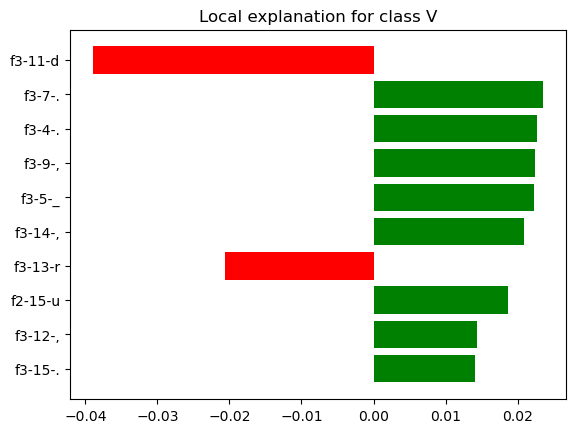

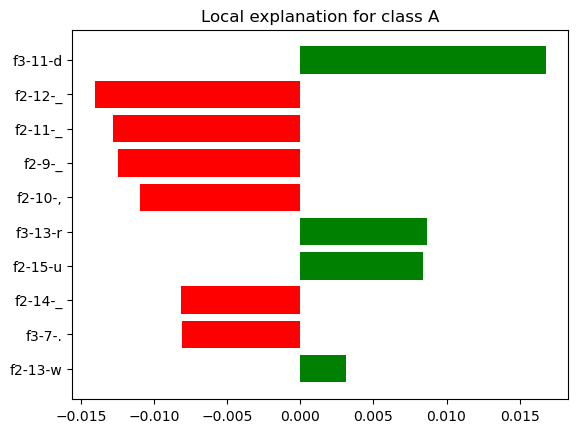

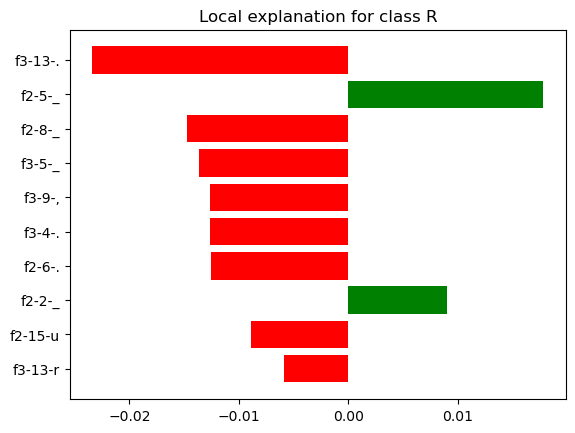

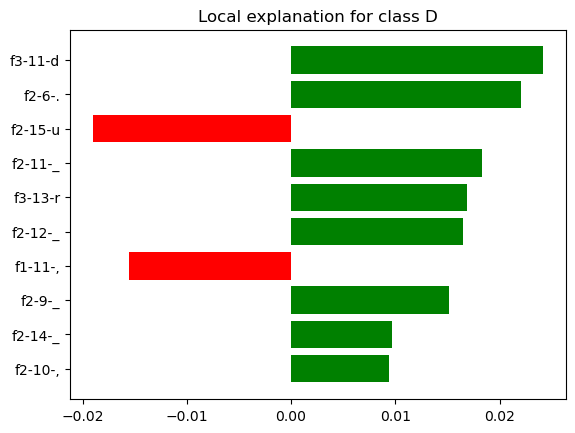

In [162]:
import matplotlib.pyplot as plt
def plot_features_all_classes(explanation):
    """
    Genera e imprime un gráfico de LIME para cada clase del modelo.
    """
    for class_idx in explanation.available_labels():  # Itera sobre todas las clases explicadas
        fig = explanation.as_pyplot_figure(label=class_idx)  # Generar el gráfico para la clase actual
        plt.show()  # Mostrar el gráfico

# Llamar a la función para visualizar todas las clases
print(f"""Muestra {i} 
{test_original[i]}""")
plot_features_all_classes(explanation_lstm)

# CNN

## Explainer

In [139]:
explainer_LIME_CNN = LimeTabularExplainer(
    training_data=x_train,  # Datos de entrenamiento (formato [N, 128])
    mode="classification",
    feature_names=feature_names_mapped,  # Nombres de las features
    class_names=["A", "D", "R", "V"],  # Nombres de las clases
    discretize_continuous=False  # LIME puede discretizar, pero es mejor desactivarlo
)


## Funcion predict

In [140]:
#  realiza la predicción sobre un conjunto de datos 
def predict_fn_LIME_CNN(x_test):
    best_cnn_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)
    
    x = data.to_conv_format(x_test)   # Convertir a la forma CNN

    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_cnn_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        return output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)


## Explicacion generada por LIME

In [167]:
# Seleccionar una muestra para explicar


# Generar la explicación
explanation_cnn = explainer_LIME_CNN.explain_instance(
    data_row=x_test[i],
    predict_fn=predict_fn_LIME_CNN,
    num_features=10,
    top_labels=4
)

# Mostrar la explicación en Jupyter Notebook
print(f"Muestra {i} a explicar {test_original[i]}")
explanation_cnn.show_in_notebook()

Muestra 3704 a explicar ['._,,.,_._,,,.,,_', '.,_,,_.,__,__w_u', '_.,.._,._,,d,r,.', 'V']


c:\Users\juand\anaconda3\lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


Muestra 3704 
['._,,.,_._,,,.,,_', '.,_,,_.,__,__w_u', '_.,.._,._,,d,r,.', 'V']


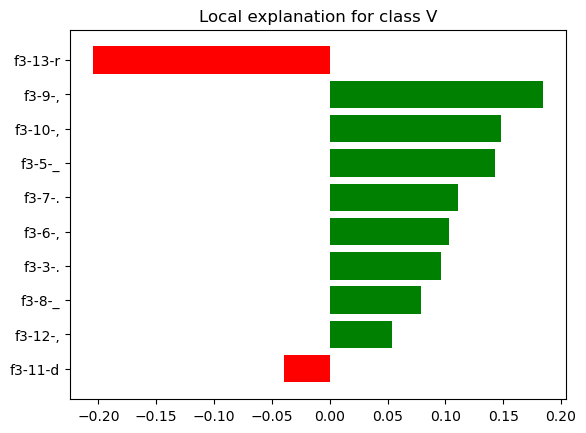

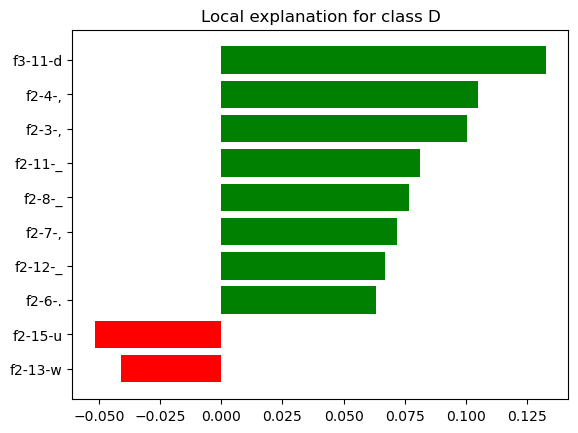

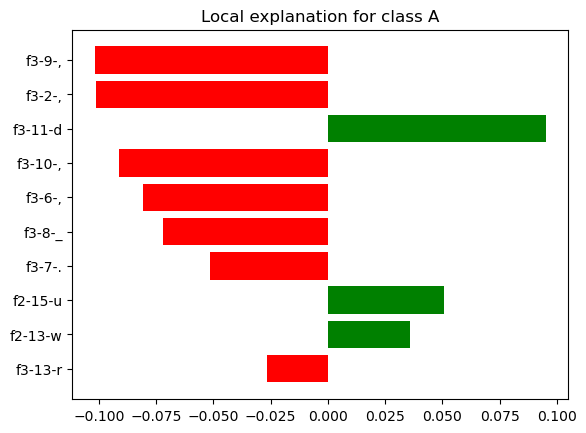

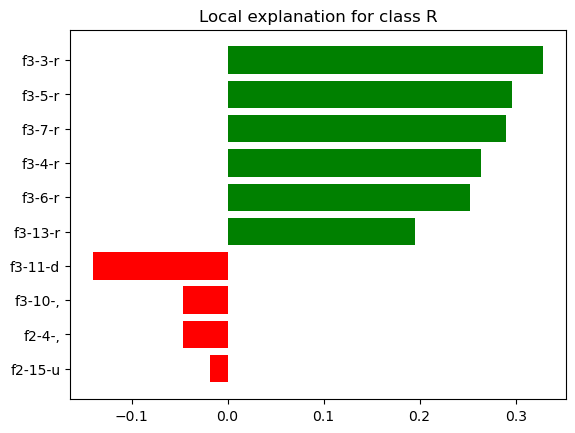

In [168]:
print(f"""Muestra {i} 
{test_original[i]}""")
plot_features_all_classes(explanation_cnn)